In [99]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import optim
from larvae import model, utils
plt.style.use("../harsh.mpl")
from sklearn.metrics import r2_score
from matplotlib import colors
from scipy import stats
import umap

load YS's mock spectra

In [3]:
w = np.load("/Users/hkamdar/Downloads/mock_all_spectra_no_noise_resample_prior_large.npz")
labels = w['labels']
l = w['wavelength']
sp = w['spectra']

let's add some noise and see what that looks like. the median SNR of APOGEE DR14 spectra is ~140. 

In [6]:
noisy_spectra, _ = utils.add_noise_to_mock_spectra(sp, snr=140)

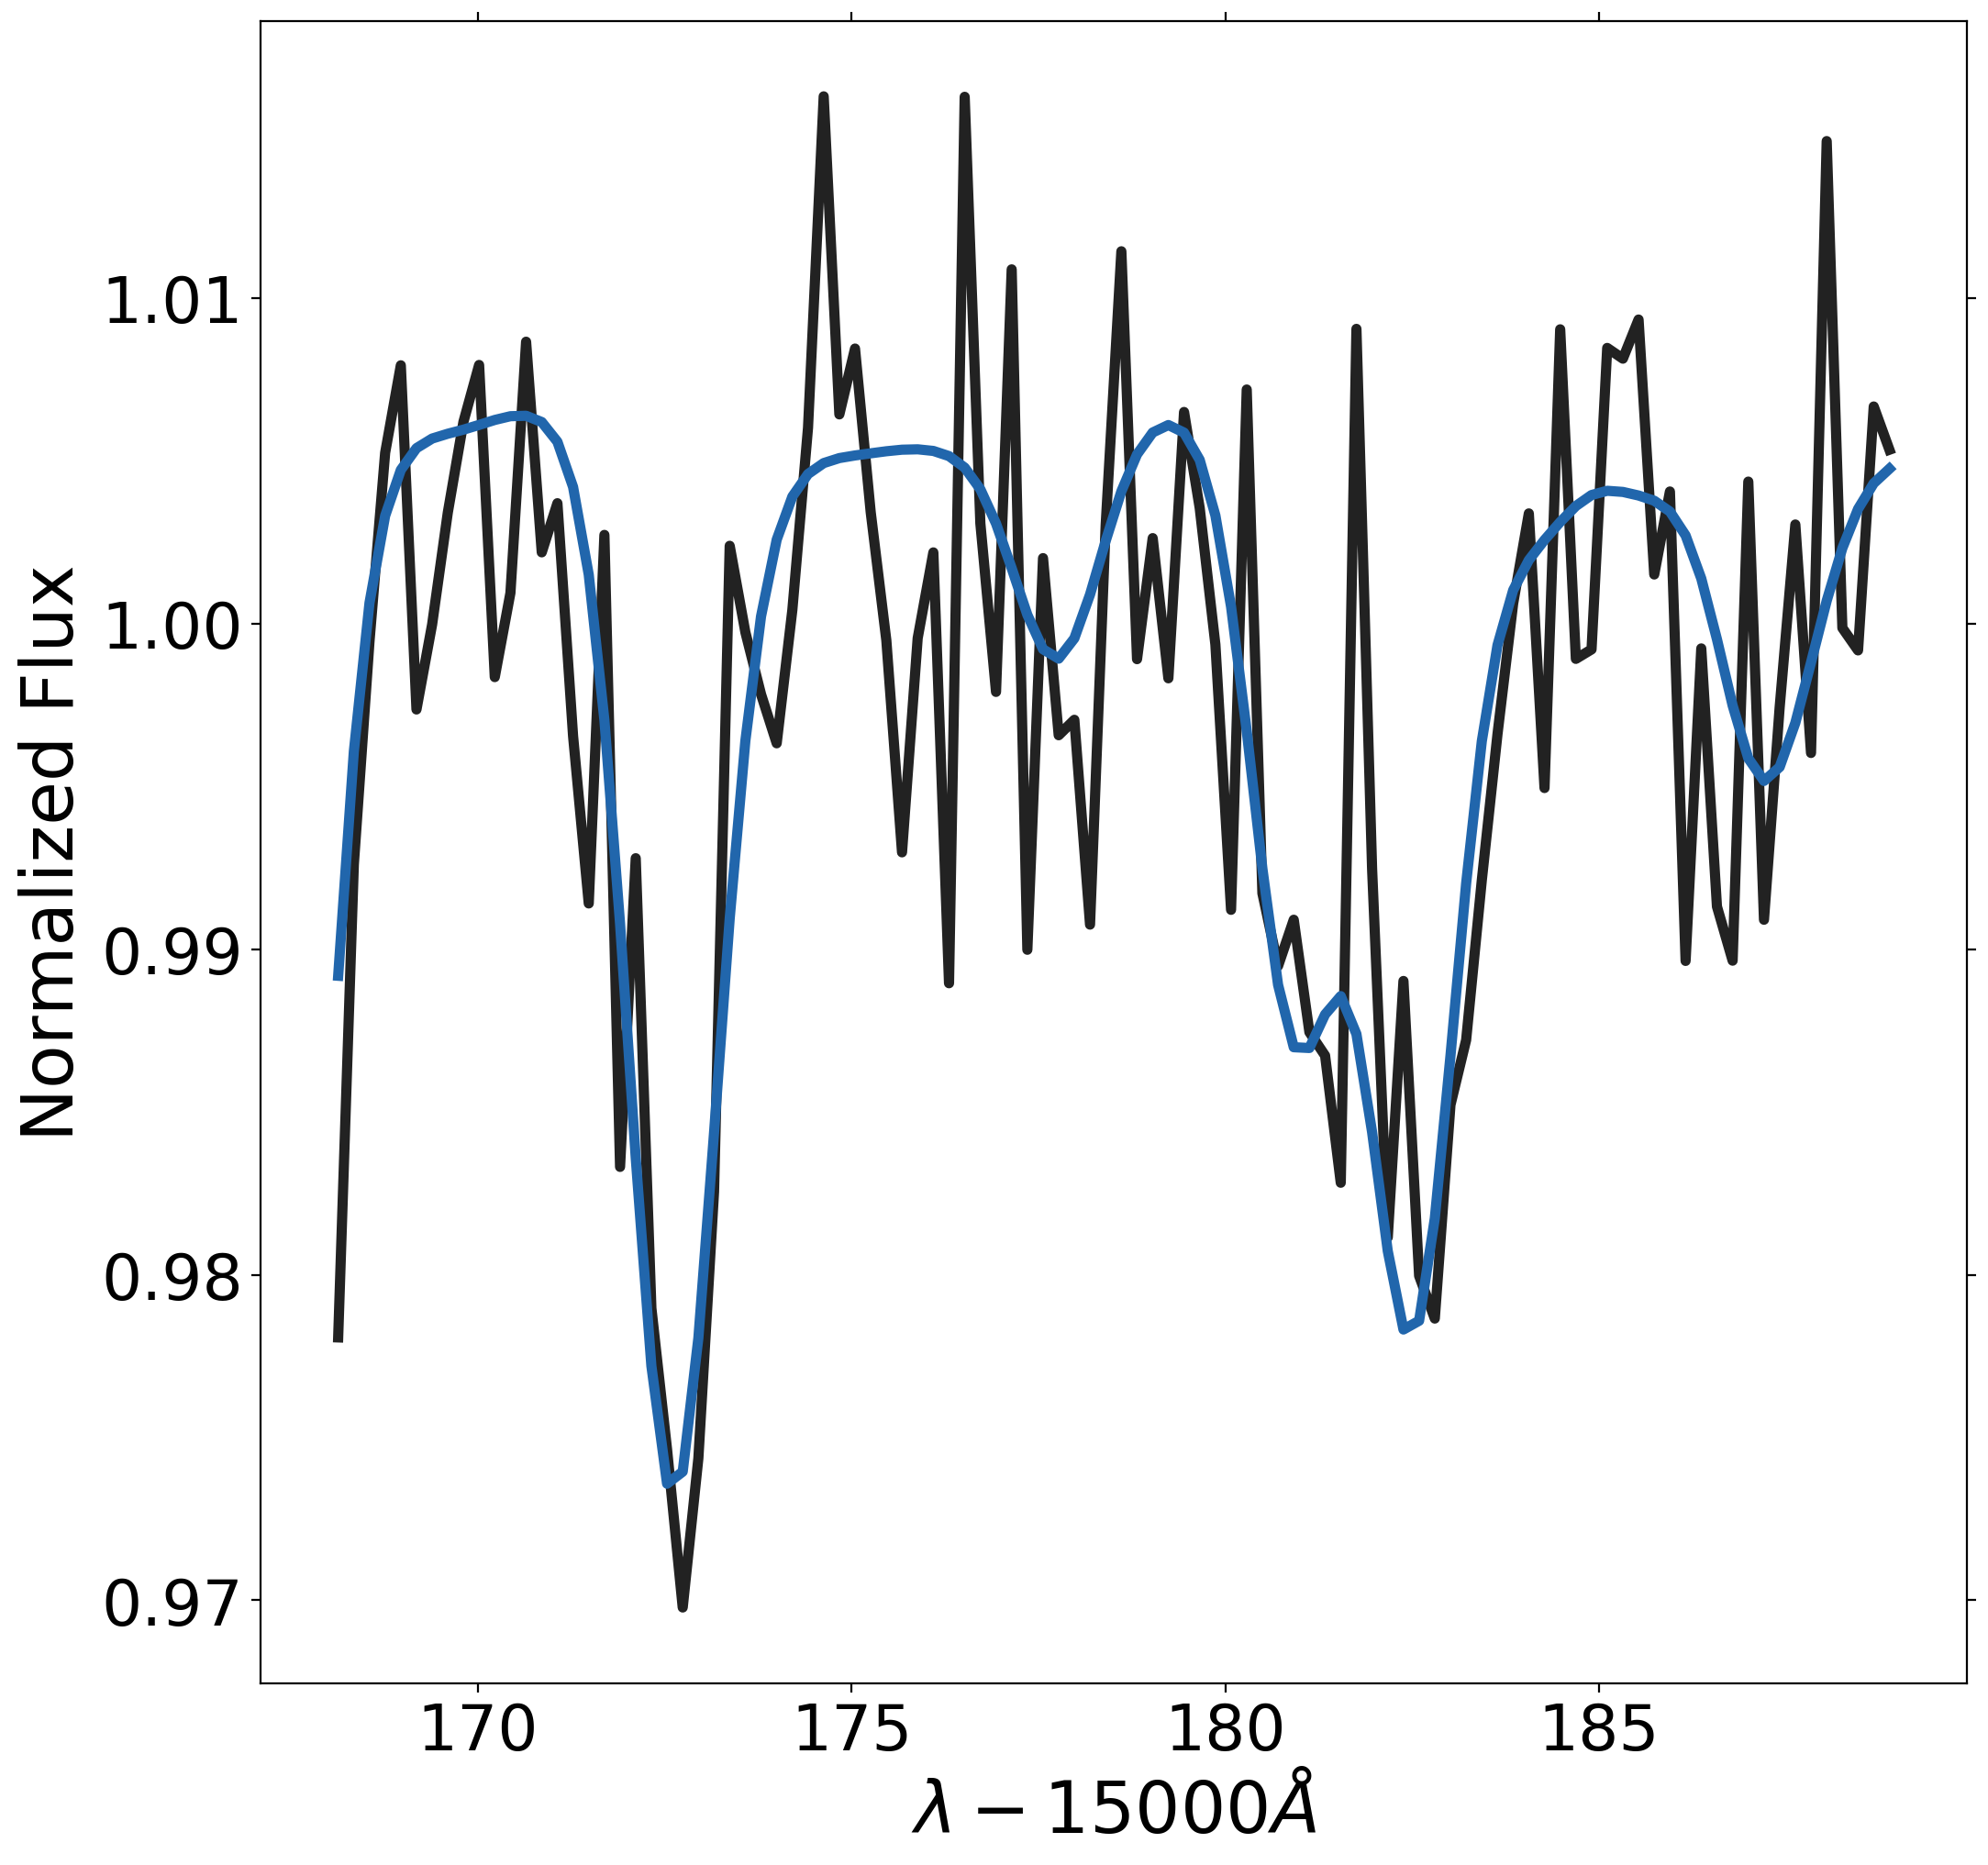

In [9]:
fig = plt.figure(figsize=(12,12))
plt.plot(l[0:100] - 15000, noisy_spectra[0,0:100], label='True')
plt.plot(l[0:100] - 15000, sp[0,0:100], label="Noisy")
plt.ylabel("Normalized Flux")
plt.xlabel(r"$\lambda - 15000 \AA$")
plt.show()

time to shuffle some data into training / test set. I will use 7,000 spectra for training and the rest for testing. we will use PyTorch's convenient DataLoader for training.

In [13]:
s = torch.Tensor(noisy_spectra)
shuffled_idxs = np.random.choice(len(s), len(s), replace=False)
train = s[shuffled_idxs[0:7000]]
test = s[shuffled_idxs[7000:]]
train_loader = torch.utils.data.DataLoader(train, batch_size=64, shuffle=True)

define the VAE model from larvae.model with 800 hidden dimensions and 30 latent dimensions (tunable). initialize the optimizer with a learning rate of 0.001 (tunable). set the total number of epochs we want to train for. 

In [18]:
vae = model.VAE(hidden_dim=800, latent_dim=30).to(torch.device("cpu"))
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
epochs = 100

In [19]:
for i in range(epochs):
    vae.train()
    train_loss = 0 #set train loss to 0 before traversing the training set
    for batch_idx, data in enumerate(train_loader):
        data = data.to(torch.device("cpu")) #no GPU
        optimizer.zero_grad() #zero out the gradients
        recon_batch, mu, logvar = vae(data) #forward pass
        loss = vae.loss_function(recon_batch, data, mu, logvar, beta=1) #calculate current loss
        loss.backward() #backpropagate 
        train_loss += loss.item() #add loss value to total loss
        optimizer.step() #gradient descent (ascent?)


    print('====> Epoch: {} Average loss: {:.4f}'.format(
          i, train_loss / len(train_loader.dataset)))

====> Epoch: 0 Average loss: 729.9189
====> Epoch: 1 Average loss: 449.3822
====> Epoch: 2 Average loss: 392.4146
====> Epoch: 3 Average loss: 366.0904
====> Epoch: 4 Average loss: 358.1679
====> Epoch: 5 Average loss: 335.3838
====> Epoch: 6 Average loss: 321.9677
====> Epoch: 7 Average loss: 309.5515
====> Epoch: 8 Average loss: 302.1421
====> Epoch: 9 Average loss: 288.9710
====> Epoch: 10 Average loss: 281.0433
====> Epoch: 11 Average loss: 276.6689
====> Epoch: 12 Average loss: 276.2033
====> Epoch: 13 Average loss: 272.4429
====> Epoch: 14 Average loss: 271.2779
====> Epoch: 15 Average loss: 265.4770
====> Epoch: 16 Average loss: 267.4658
====> Epoch: 17 Average loss: 261.3758
====> Epoch: 18 Average loss: 253.5413
====> Epoch: 19 Average loss: 251.9014
====> Epoch: 20 Average loss: 248.6617
====> Epoch: 21 Average loss: 247.6242
====> Epoch: 22 Average loss: 248.2097
====> Epoch: 23 Average loss: 246.2325
====> Epoch: 24 Average loss: 242.6890
====> Epoch: 25 Average loss: 240.0

alright, the model is trained. let's try to recreate an individual star's spectrum to see how good the generative model is. 

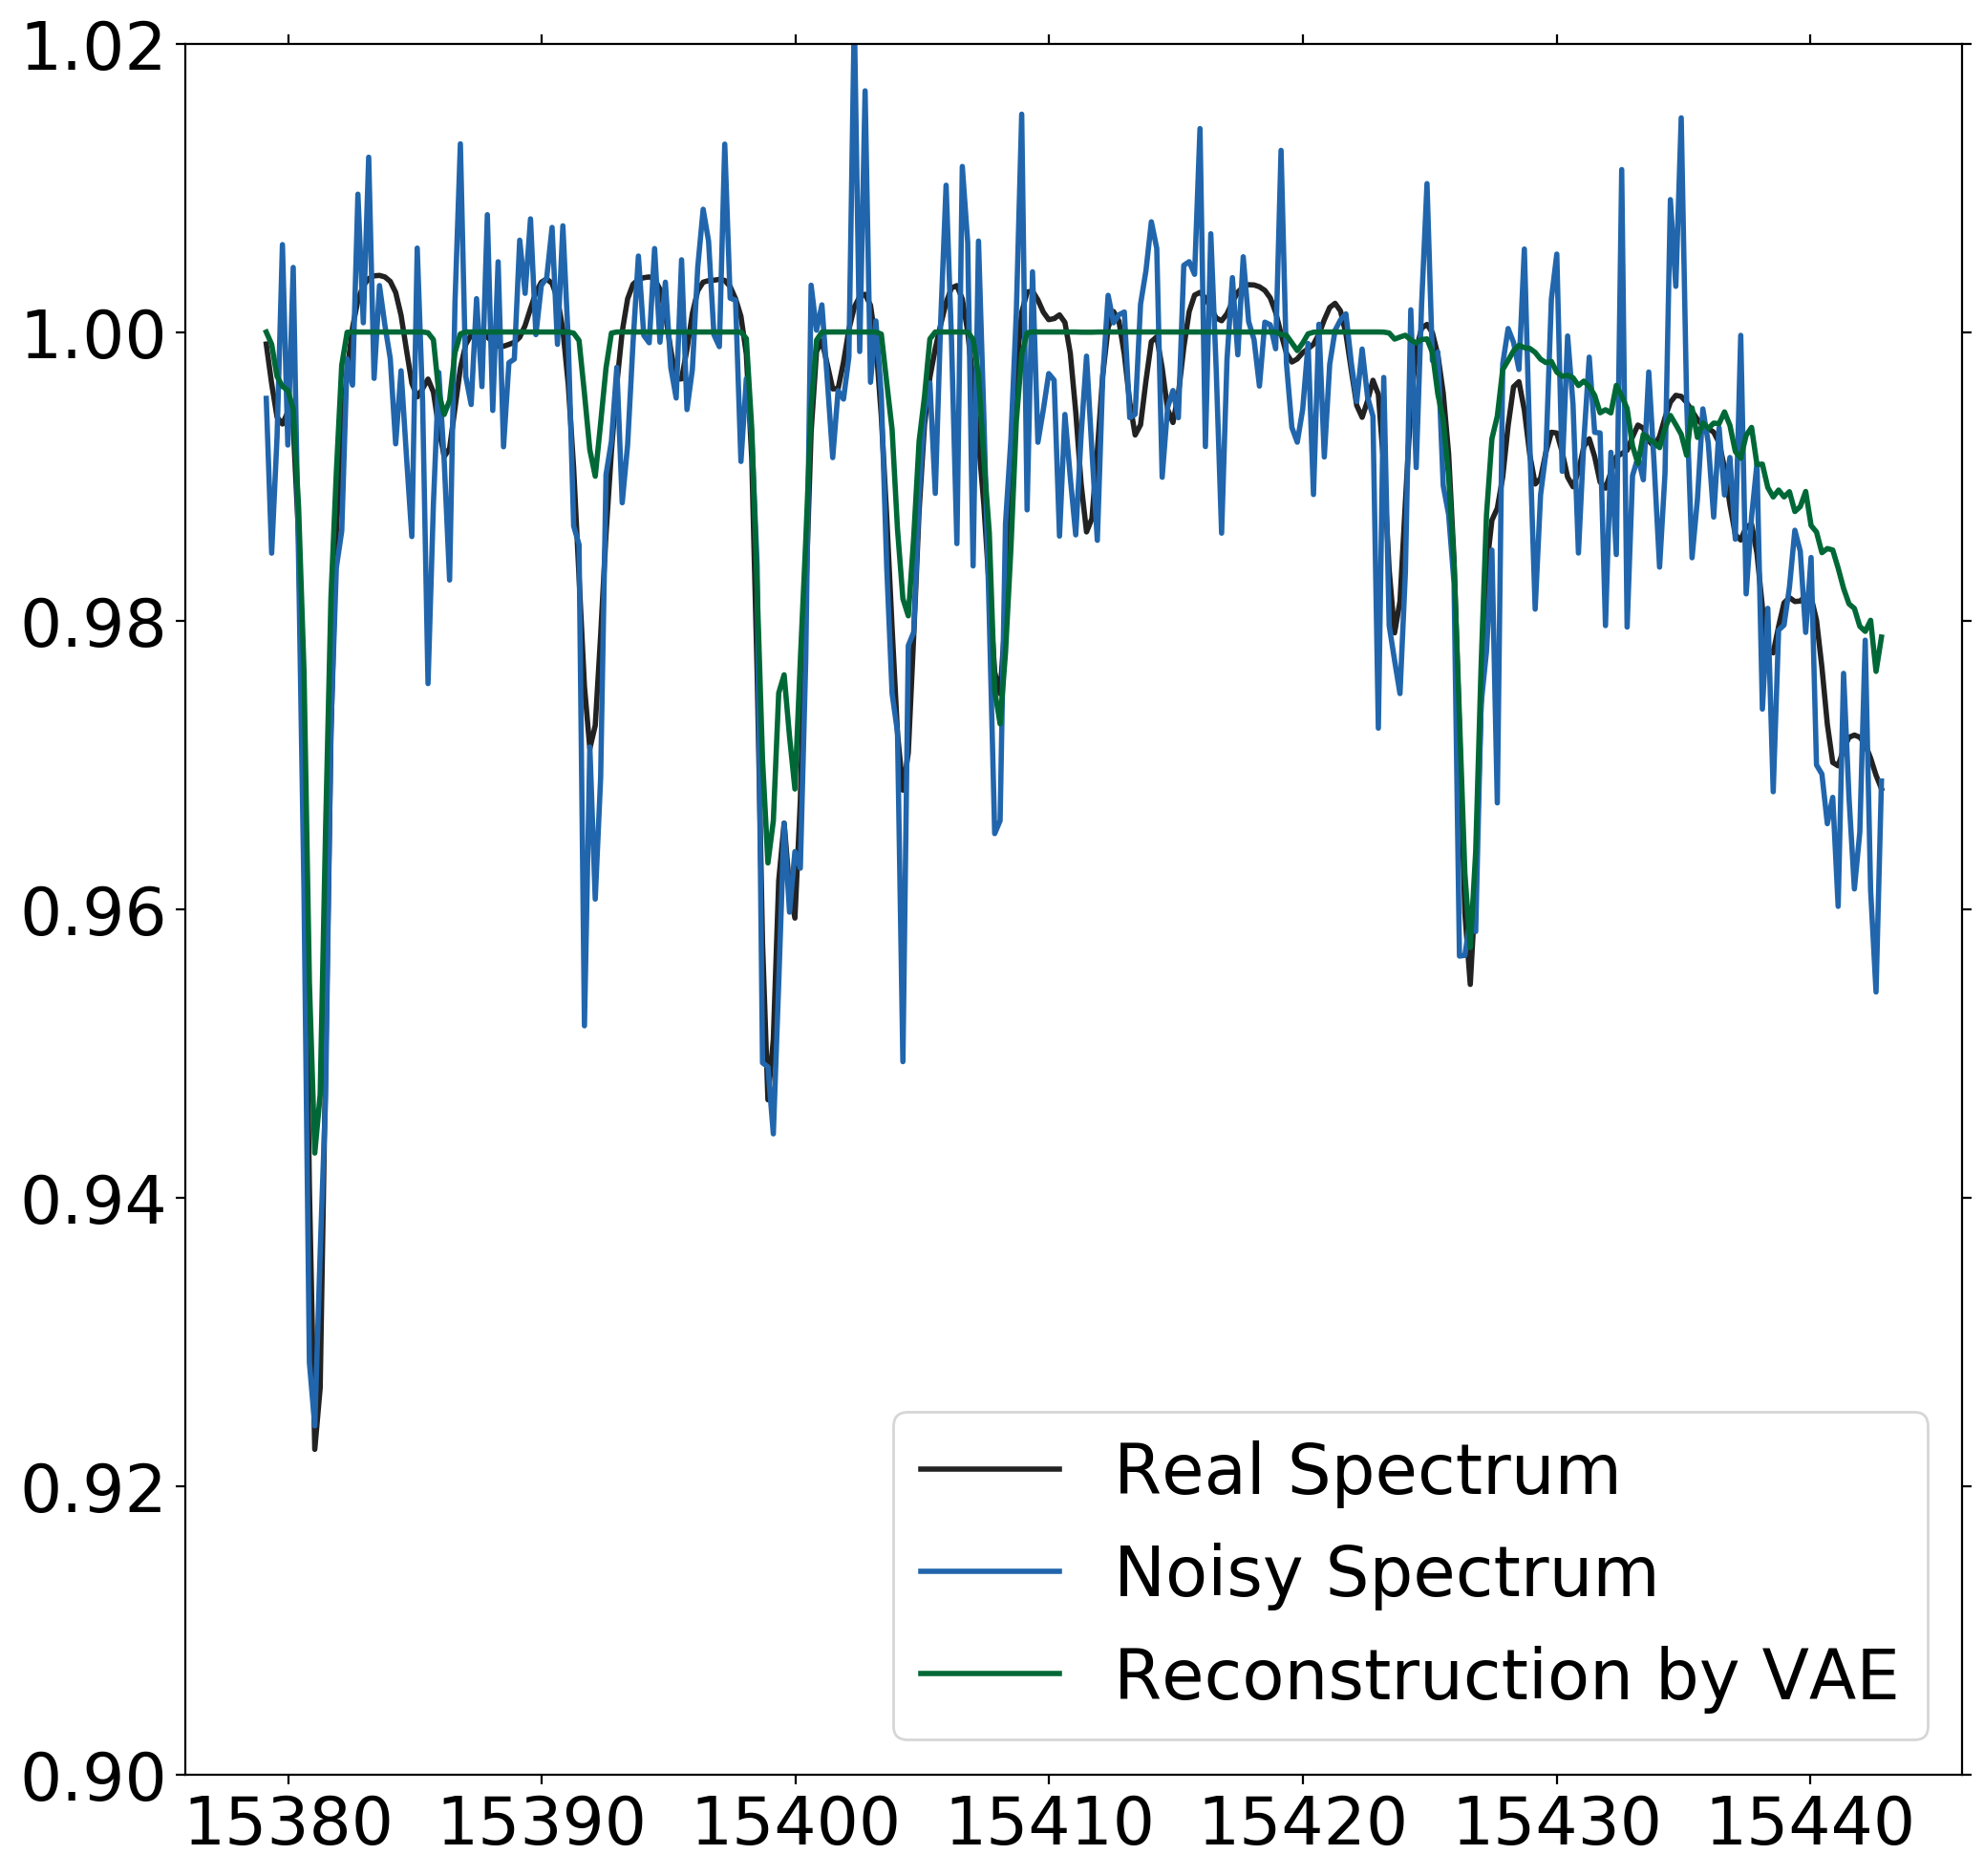

In [101]:
fig = plt.figure()
choose_star = np.random.choice(len(test), 1)
plotting_window = (1000, 1300)
plt.plot(l[plotting_window[0]:plotting_window[1]], sp[shuffled_idxs[7000+choose_star][0]][plotting_window[0]:plotting_window[1]], linewidth=2, label="Real Spectrum")
plt.plot(l[plotting_window[0]:plotting_window[1]], test[choose_star[0]][plotting_window[0]:plotting_window[1]], linewidth=2, label="Noisy Spectrum")
plt.plot(l[plotting_window[0]:plotting_window[1]], vae(test[choose_star[0]])[0].detach().numpy()[0][plotting_window[0]:plotting_window[1]], linewidth=2, label="Reconstruction by VAE")
plt.ylim([0.90, 1.02])
plt.legend(loc='best')

nice! that was just one random example though. how do things look for the whole test sample? the next plot shows the  residual for each pixel averaged over all stars in the test set. And the line is a binned mean. 

In [116]:
diffs = []
for i in range(len(test)):
    diffs.append((vae(test[i])[0].detach().numpy()[0]) - test[i].detach().numpy())
d = np.array(diffs)

(-0.02, 0.02)

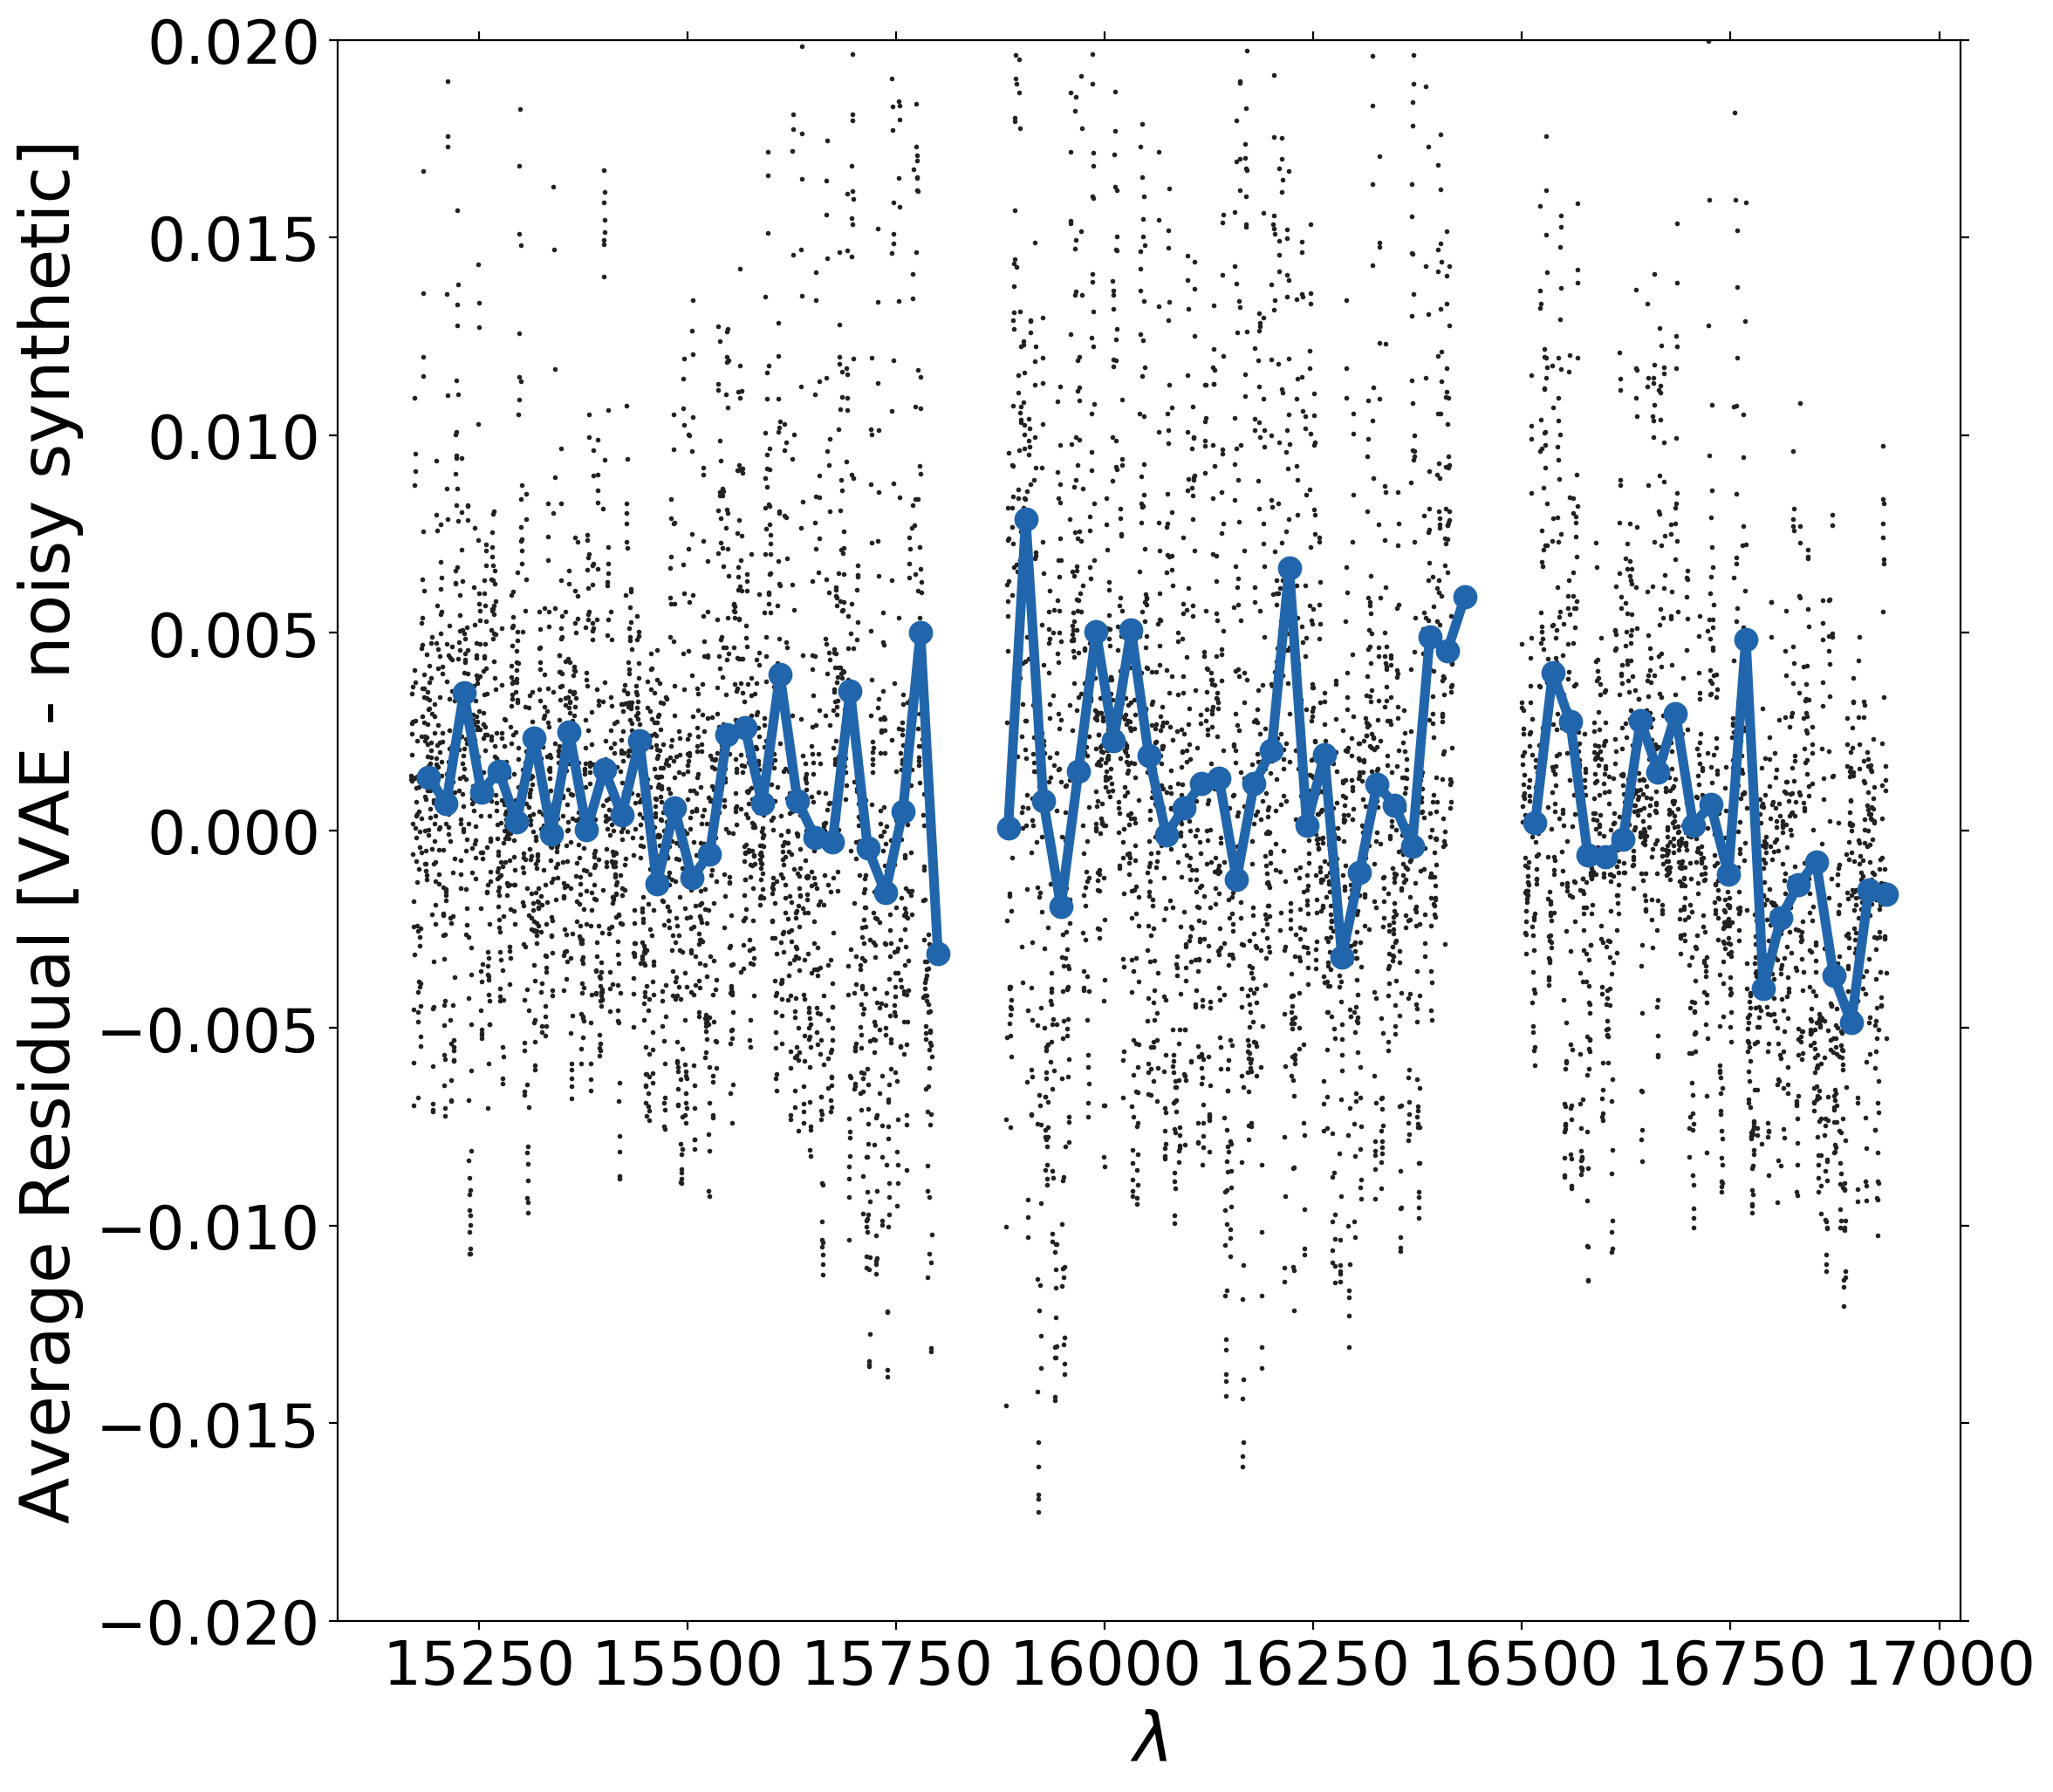

In [117]:
fig = plt.figure(figsize=(12,12))
plt.plot(l, np.mean(d,axis=0), 'o')
values, bins, _ = stats.binned_statistic(l, np.mean(d,axis=0), bins=int(np.sqrt(len(l))))
plt.plot(bins[1:], values, 'o-', markersize=10)
plt.ylabel("Average Residual [VAE - noisy synthetic]")
plt.xlabel(r"$\lambda$")
plt.ylim([-0.02, 0.02])

residuals look good. VAEs (on average) are able to reconstruct the spectra from the test set pretty well!

In [118]:
r2s = []
for i in range(len(test)):
    r2s.append(r2_score(test[i].detach().numpy(), (vae(test[i])[0].detach().numpy()[0])))

In [119]:
teff = labels[0,:]
logg = labels[1,:]
feh = labels[18,:]
mgfe = labels[7,:] - feh

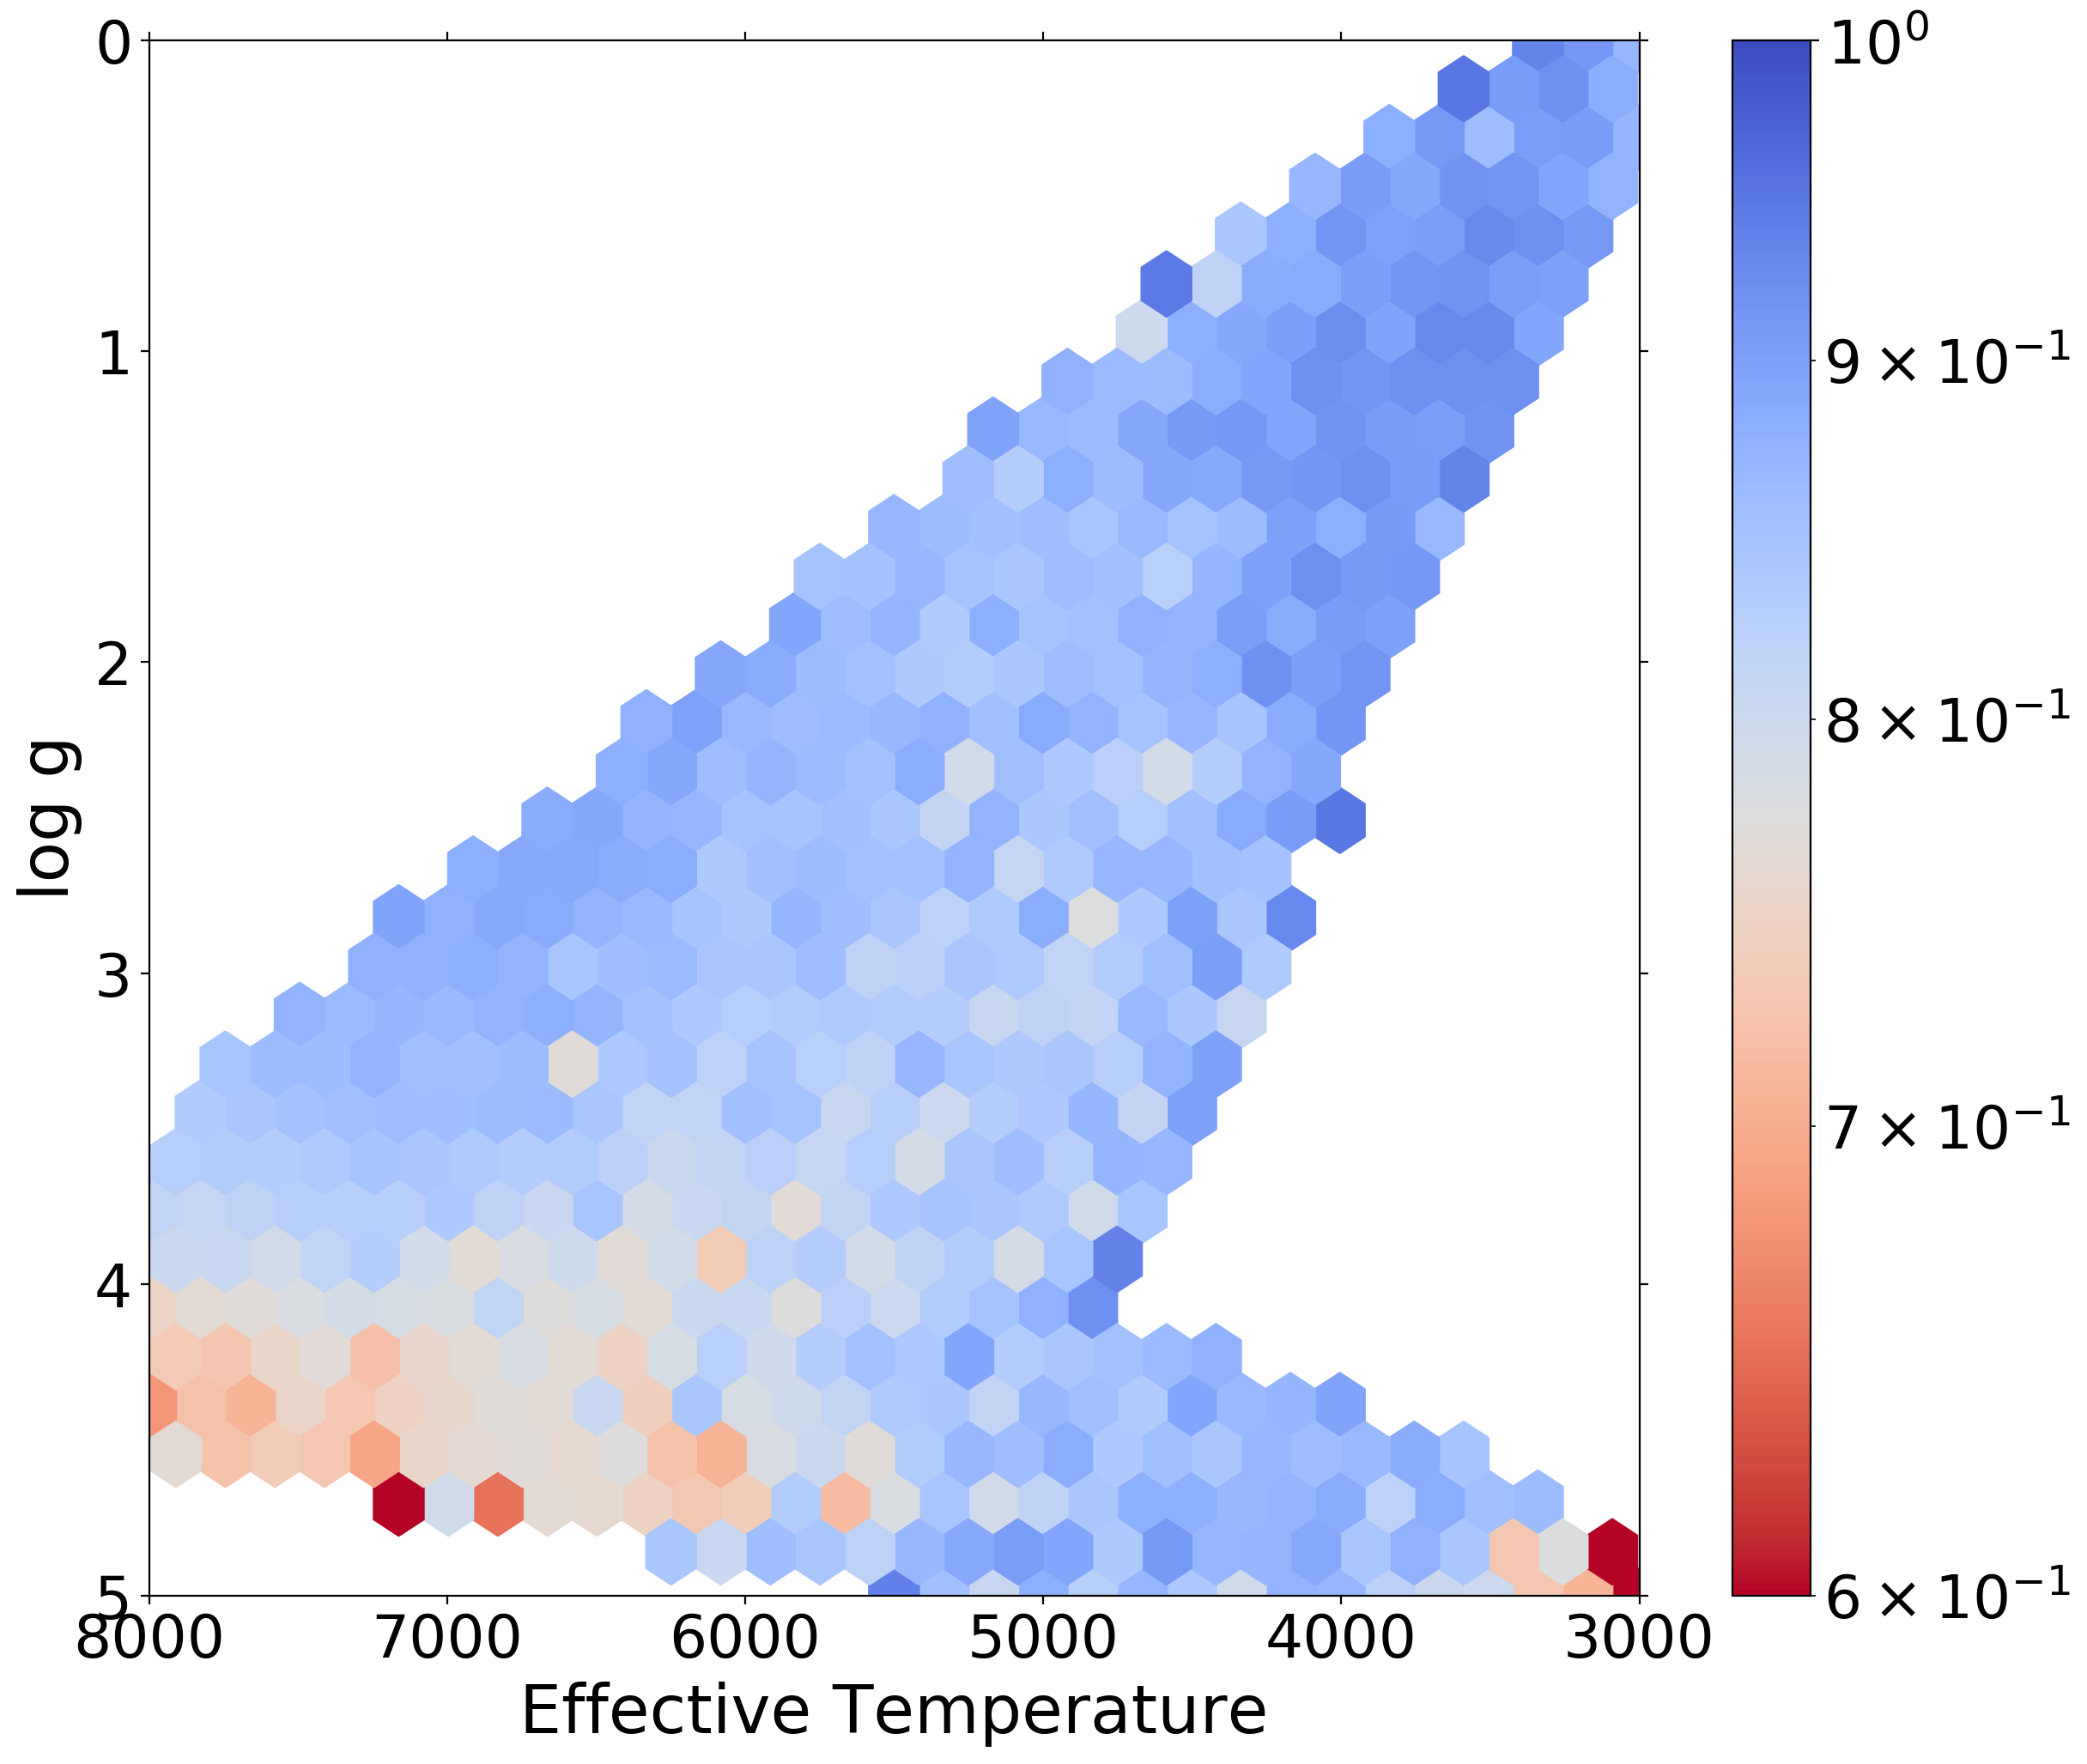

In [139]:
fig = plt.figure(figsize=(14,12))
plt.hexbin(teff[shuffled_idxs[7000:]], logg[shuffled_idxs[7000:]], gridsize=30, C=r2s, cmap=plt.cm.coolwarm_r, norm=colors.LogNorm(), vmin=0.6, vmax=1.0)
plt.colorbar()
plt.xlim([8000, 3000])
plt.ylim([5, 0])
plt.xlabel("Effective Temperature")
plt.ylabel("log g")
plt.show()

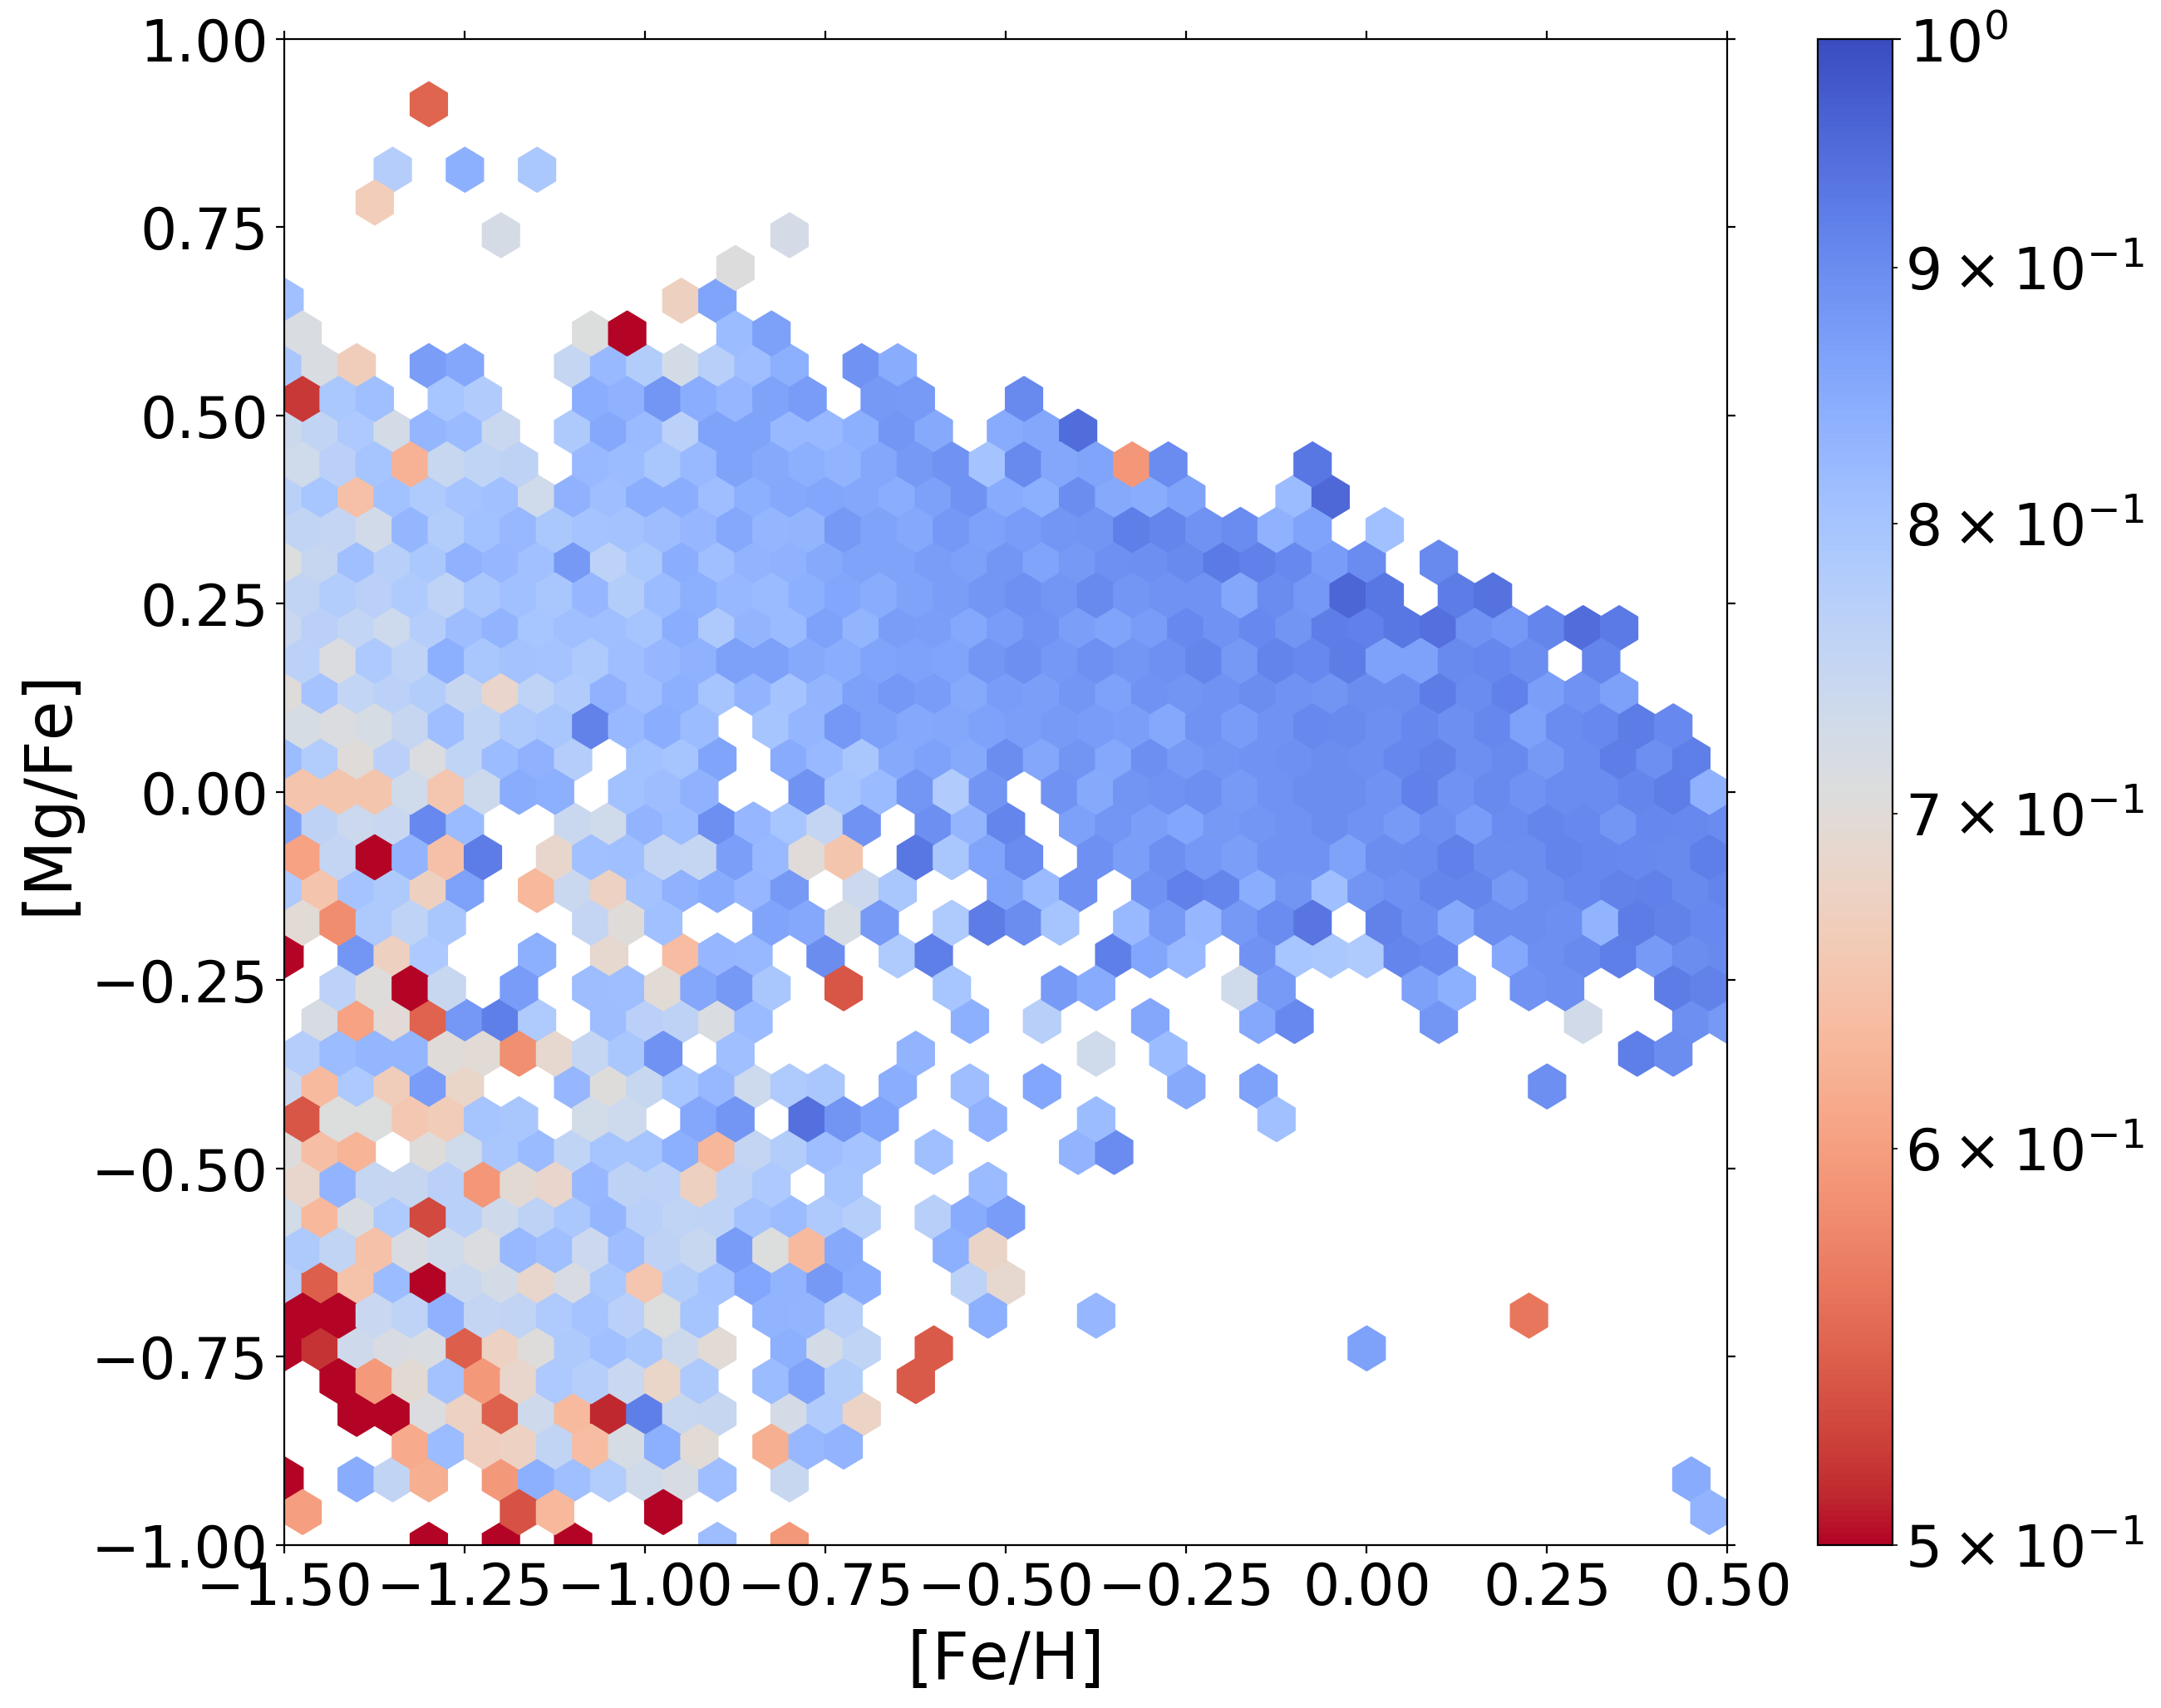

In [144]:
fig = plt.figure(figsize=(14,12))
plt.hexbin(feh[shuffled_idxs[7000:]], mgfe[shuffled_idxs[7000:]], gridsize=40, C=r2s, cmap=plt.cm.coolwarm_r, norm=colors.LogNorm(), vmin=0.5, vmax=1.0, extent=[-1.5, 0.5, -1, 1])
plt.colorbar()
plt.xlim([-1.5, 0.5])
plt.ylim([-1, 1])
plt.xlabel("[Fe/H]")
plt.ylabel("[Mg/Fe]")
plt.show()

In [140]:
mu = (vae(test)[1]).detach().numpy()
reducer = umap.UMAP()
embedding = reducer.fit_transform(mu)

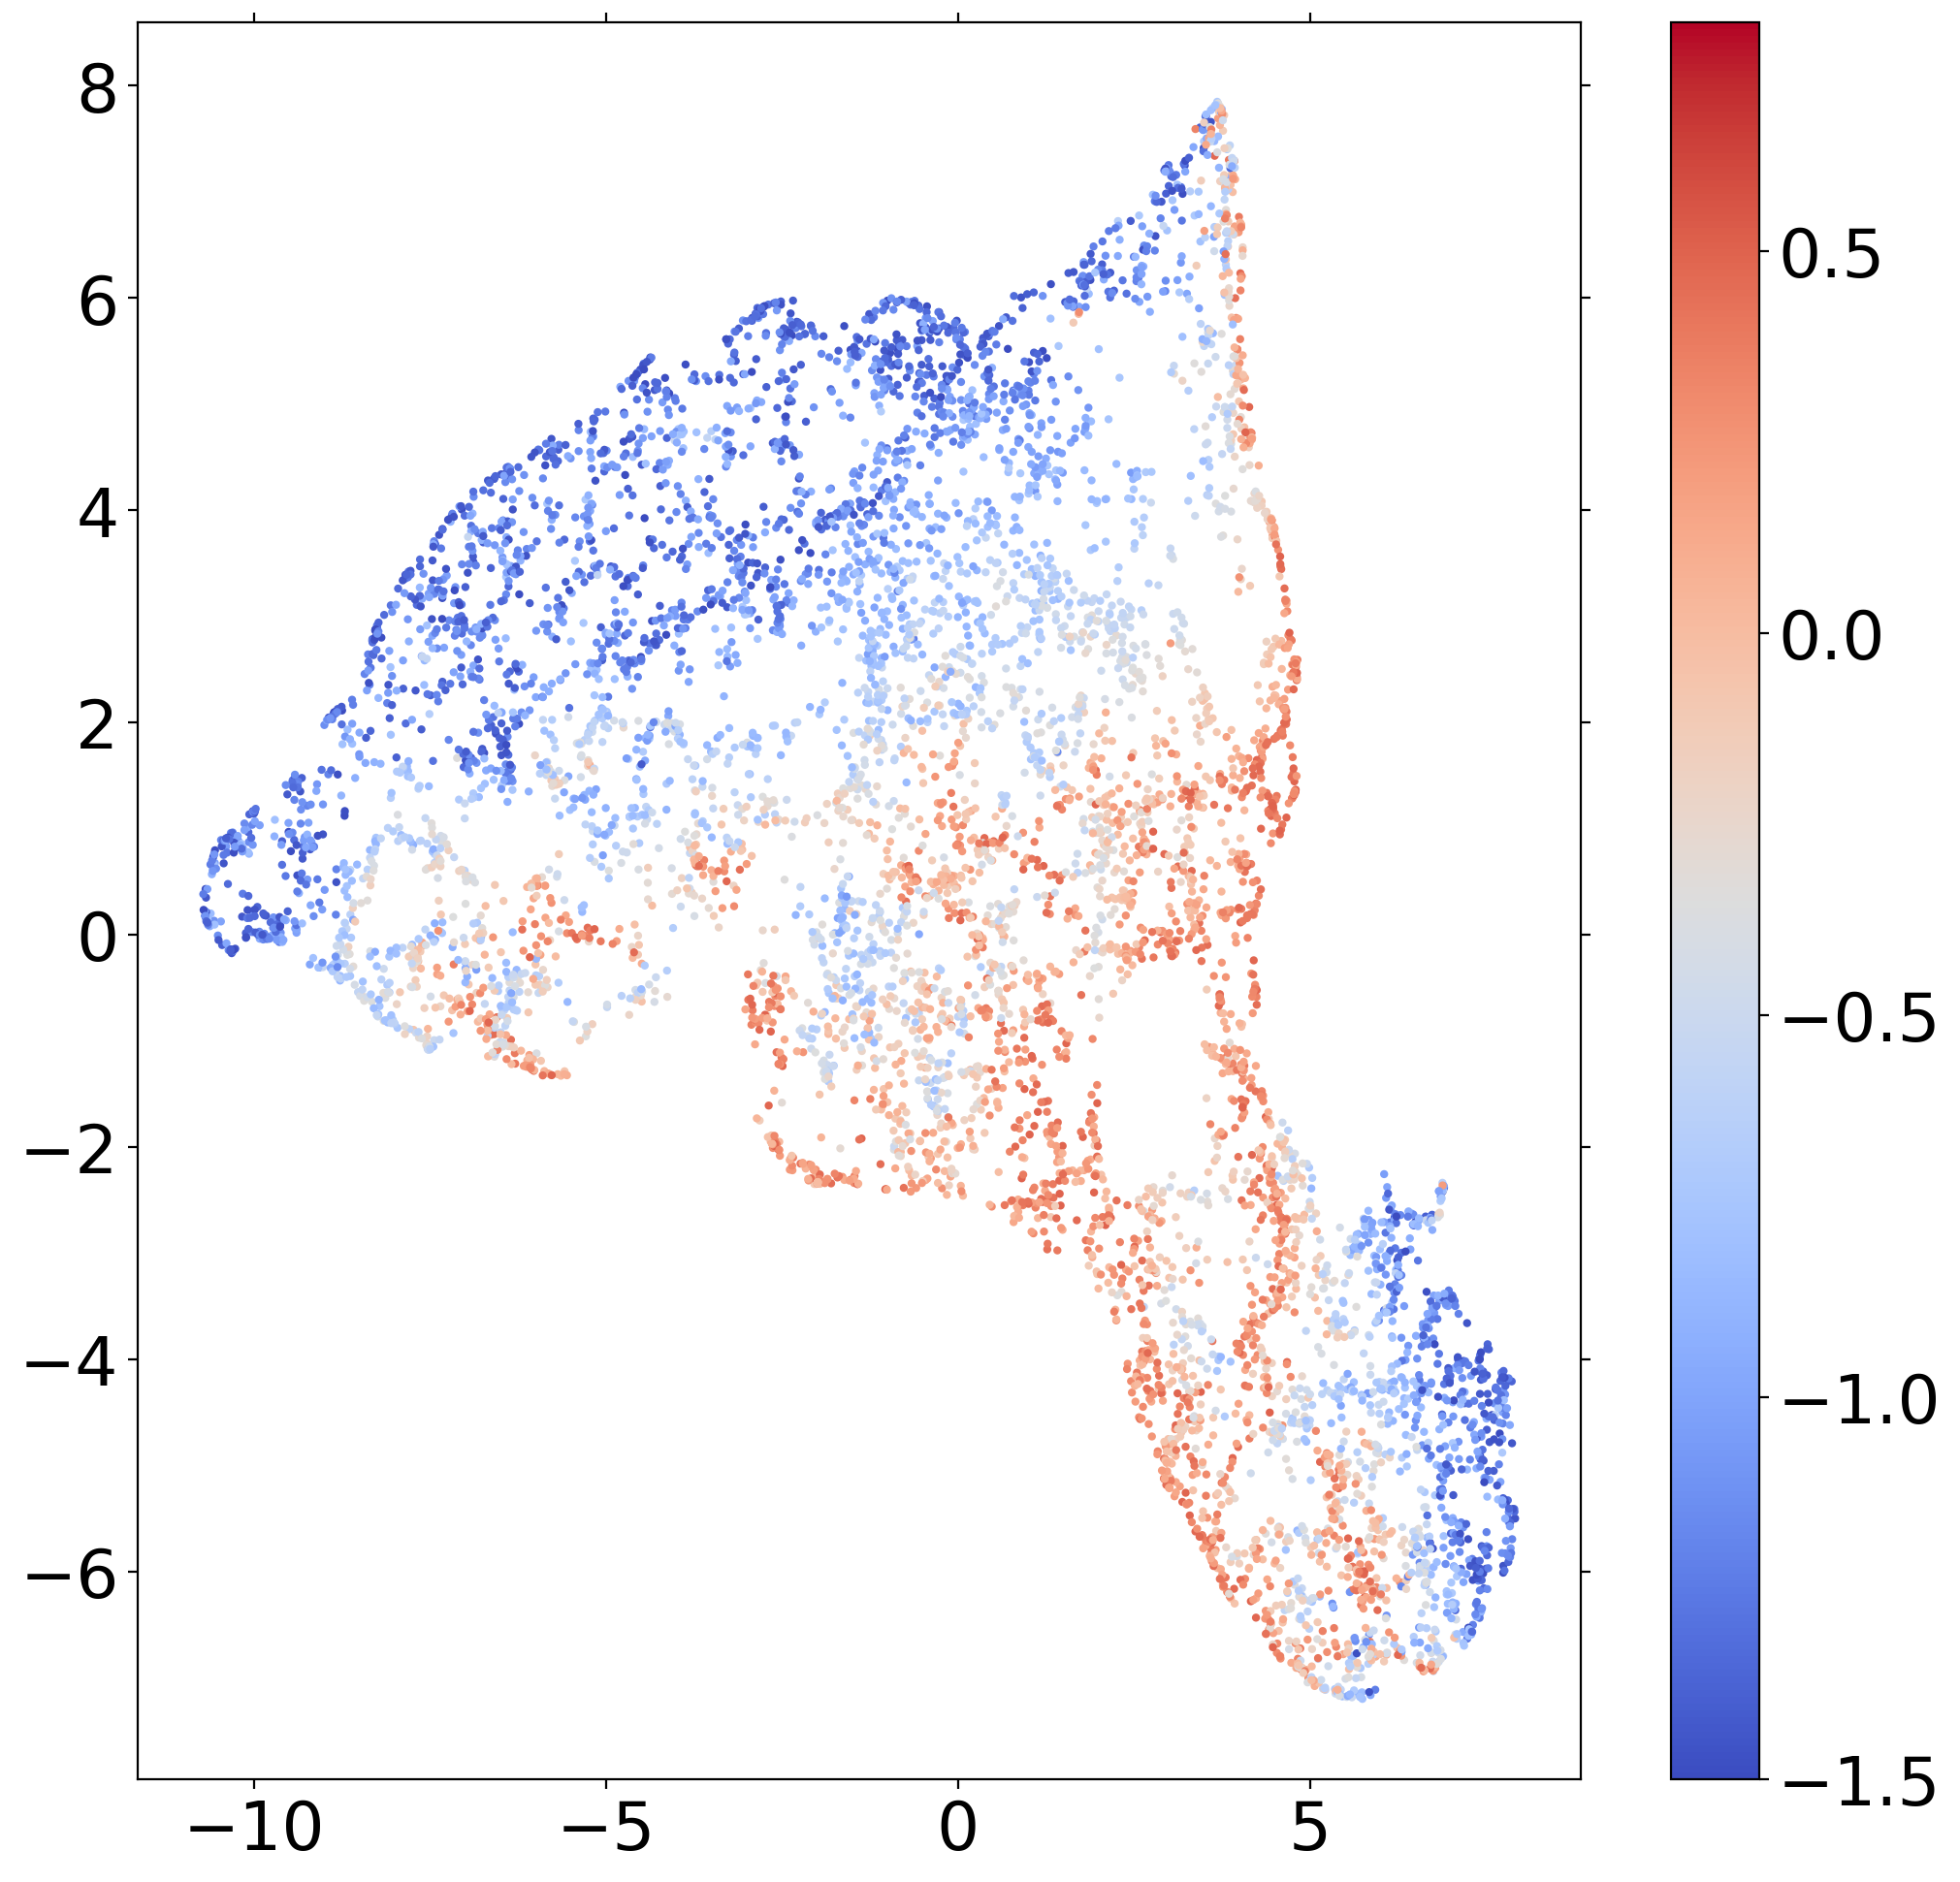

In [143]:
fig = plt.figure(figsize=(12,12))
plt.scatter(embedding[:,0], embedding[:,1], c=feh[shuffled_idxs[7000:]], cmap=plt.cm.coolwarm, vmin=-1.5, vmax=0.8)
plt.colorbar()